In [1]:
!pip install sdv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.5/70.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.3/160.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.4
    Uninstalling urllib3-2.0.4:
      Successfully uninstalled urllib3-2.0.4


In [2]:
from sdv.single_table import CTGANSynthesizer
from sdv.sequential import PARSynthesizer
from sdv.metadata import SingleTableMetadata
import numpy as np
import pandas as pd
from sdv.sampling import Condition
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ln -s /content/drive/MyDrive/Colab\ Notebooks/DACON/dacon-lettuce-generative /mydrive

In [5]:
!mkdir /content/dataset
!cd /mydrive; unzip open.zip -d /content/dataset

Archive:  open.zip
  inflating: /content/dataset/sample_submission.zip  
   creating: /content/dataset/test_input/
  inflating: /content/dataset/test_input/TEST_01.csv  
  inflating: /content/dataset/test_input/TEST_02.csv  
  inflating: /content/dataset/test_input/TEST_03.csv  
  inflating: /content/dataset/test_input/TEST_04.csv  
  inflating: /content/dataset/test_input/TEST_05.csv  
   creating: /content/dataset/test_target/
  inflating: /content/dataset/test_target/TEST_01.csv  
  inflating: /content/dataset/test_target/TEST_02.csv  
  inflating: /content/dataset/test_target/TEST_03.csv  
  inflating: /content/dataset/test_target/TEST_04.csv  
  inflating: /content/dataset/test_target/TEST_05.csv  
   creating: /content/dataset/train_input/
  inflating: /content/dataset/train_input/CASE_01.csv  
  inflating: /content/dataset/train_input/CASE_02.csv  
  inflating: /content/dataset/train_input/CASE_03.csv  
  inflating: /content/dataset/train_input/CASE_04.csv  
  inflating: /conten

In [ ]:
# data load & preprocessing
def make_traindata_ctgan(input_dir_list):
  train_all = pd.DataFrame()
  for i in range(len(input_dir_list)):
    train_df = pd.read_csv(input_dir_list[i])
    train_df['Case'] = i + 1
    train_all = pd.concat([train_all, train_df])
  train_all['obs_time'] = pd.to_datetime(train_all['obs_time'])
  train_all['obs_time'] = train_all['obs_time'].dt.hour

  # 이상값 처리
  # 내부온도,습도=0 -> 평균으로 대체
  # print(round(train_all[(train_all['DAT'] == 0) & (train_all['obs_time'] == 15) & (train_all['Case'] != 4)]['내부온도관측치'].mean(), 6))
  # print(round(train_all[(train_all['DAT'] == 0) & (train_all['obs_time'] == 15) & (train_all['Case'] != 4)]['내부습도관측치'].mean(), 6))
  train_all.loc[train_all['내부온도관측치'] == 0, '내부온도관측치'] = 28.479124
  train_all.loc[train_all['내부습도관측치'] == 0, '내부습도관측치'] = 53.469956

  # 시간당분무량<0 -> 0으로 대체
  train_all.loc[train_all['시간당분무량'] < 0, '시간당분무량'] = 0

  # 시간당백색,적색,청색광량<0 -> 최빈값으로 대체
  # print(train_all.loc[train_all['시간당백색광량'] < 0, ['DAT', 'obs_time', 'Case']])
  # print(train_all.loc[train_all['시간당적색광량'] < 0, ['DAT', 'obs_time', 'Case']])
  # print(train_all.loc[train_all['시간당청색광량'] < 0, ['DAT', 'obs_time', 'Case']])
  # print(train_all[(train_all['DAT'] == 0) & (train_all['obs_time'] == 15) & (train_all['Case'] != 6)]['시간당백색광량'].mode())
  # print(train_all[(train_all['DAT'] == 0) & (train_all['obs_time'] == 15) & (train_all['Case'] != 6)]['시간당적색광량'].mode())
  # print(train_all[(train_all['DAT'] == 0) & (train_all['obs_time'] == 15) & (train_all['Case'] != 6)]['시간당청색광량'].mode())
  train_all.loc[train_all['시간당백색광량'] < 0, '시간당백색광량'] = 18255.19
  train_all.loc[train_all['시간당적색광량'] < 0, '시간당적색광량'] = 0
  train_all.loc[train_all['시간당청색광량'] < 0, '시간당청색광량'] = 0

  # 누적, 시간당총광량 column 삭제
  col_names = train_all.columns
  drop_feature_list = ['DAT', 'obs_time', 'Case', '시간당총광량']
  for col in col_names:
    if '누적' in col or col in drop_feature_list:
      train_all = train_all.drop(col, axis=1)

  # print(train_all)
  # 시간별 데이터 -> 일별 데이터
  train_list = []
  train_len = int(train_all.shape[0] / 24)

  for i in range(train_len):
    day_data = train_all[24*i:24*(i+1)]
    time_series = day_data.values.flatten().tolist() + [i%28]
    train_list.append(time_series)

  all_col = []
  for hour in range(24):
    for col in train_all.columns:
      all_col.append(f'{hour}시_{col}')
  all_col.append('day')

  train = pd.DataFrame(train_list, columns=all_col)

  return train

In [ ]:
# synthetic data -> raw data
def make_raw (df, day):
  df_numpy = df.values
  return_arr = []

  for i in range(len(df_numpy)) :
    now = df_numpy[i]
    for j in range(24):
      value = np.insert(now[j*8:j*8+8],0, int(day)) # dat
      value = np.insert(value , 1 ,int(j)) # obs_time
      value = np.insert(value , 0 ,int(i)) # case
      return_arr.append(value.tolist())

  return_df = pd.DataFrame(np.array(return_arr),columns = ['Case','DAT', 'obs_time', '내부온도관측치', '내부습도관측치','co2관측치',
                                      'ec관측치', '시간당분무량', '시간당백색광량',  '시간당적색광량',  '시간당청색광량' ])

  return_df['시간당총광량'] = return_df['시간당백색광량'] + return_df['시간당적색광량'] + return_df['시간당청색광량']

  # 중앙값 차이 값으로 값 변환
  # return_df['내부온도관측치'] =  return_df['내부온도관측치']  - 2
  # return_df['시간당분무량'] = return_df['시간당분무량'] + 1251.865000
  # return_df['ec관측치'] = return_df['ec관측치'] +1.7

  cumsum_list = ['일간누적분무량', '일간누적백색광량', '일간누적적색광량', '일간누적청색광량', '일간누적총광량']
  per_time_list = ['시간당분무량', '시간당백색광량', '시간당적색광량', '시간당청색광량', '시간당총광량']

  for i in range(0, 5):
    col1 = cumsum_list[i]
    col2 = per_time_list[i]
    return_df[col1] = 0
    return_df[col1] = return_df.groupby((return_df.obs_time == 0).cumsum()).agg(col2).cumsum()

  return_df = return_df[['Case', 'DAT', 'obs_time', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량',
            '일간누적분무량', '시간당백색광량', '일간누적백색광량', '시간당적색광량', '일간누적적색광량', '시간당청색광량',
            '일간누적청색광량', '시간당총광량', '일간누적총광량']]

  return return_df

In [ ]:
def generate_synth(synthesizer, days):
  synthetic_data = synthesizer.sample(num_rows=days)
  n = synthetic_data.shape[0]
  gen_data = pd.DataFrame()
  for i in range(n):
    synth_dayi = synthetic_data.loc[[i]]
    raw_dayi = make_raw(synth_dayi, i)
    gen_data = pd.concat([gen_data, raw_dayi], axis=0).reset_index(drop=True)
  return gen_data

In [ ]:
def generate_cond_synth(synthesizer, days):
  gen_data = pd.DataFrame()
  for i in range(days):
    dayi = Condition(num_rows=1, column_values={'day': i})
    synthetic_data_dayi = synthesizer.sample_from_conditions(conditions=[dayi])
    raw_data_dayi = make_raw(synthetic_data_dayi, i)
    gen_data = pd.concat([gen_data, raw_data_dayi], axis=0).reset_index(drop=True)
  return gen_data

In [ ]:
def plot_real_synth(real, synth):
  col_names = ['내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량',
            '시간당백색광량', '시간당적색광량', '시간당청색광량', '시간당총광량']
  title_names = ['temp', 'humidity', 'co2', 'ec', 'water', 'white_light', 'red_light', 'blue_light', 'total_light']

  fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20,10))
  axs = axs.ravel(order='C')
  for i, col in enumerate(col_names):
    axs[i].plot(real[col].reset_index(drop=True), label='real', color='red')
    axs[i].plot(synth[col].reset_index(drop=True), label='synth', color='blue', linestyle='--')
    axs[i].legend()
    axs[i].set_title(title_names[i])
  plt.tight_layout()
  plt.show()

### CTGAN

1.   Train input - CASE_01~28.csv



In [ ]:
synthesizer = CTGANSynthesizer.load(
    filepath='/mydrive/model_param/my_synthesizer.pkl'
)

In [ ]:
train_c1 = pd.read_csv('/content/dataset/train_input/CASE_01.csv') # CASE_01.csv
train_c1d0 = train_c1[train_c1['DAT'] == 0] # 'DAT'=0

In [ ]:
synth = generate_synth(synthesizer, 1)

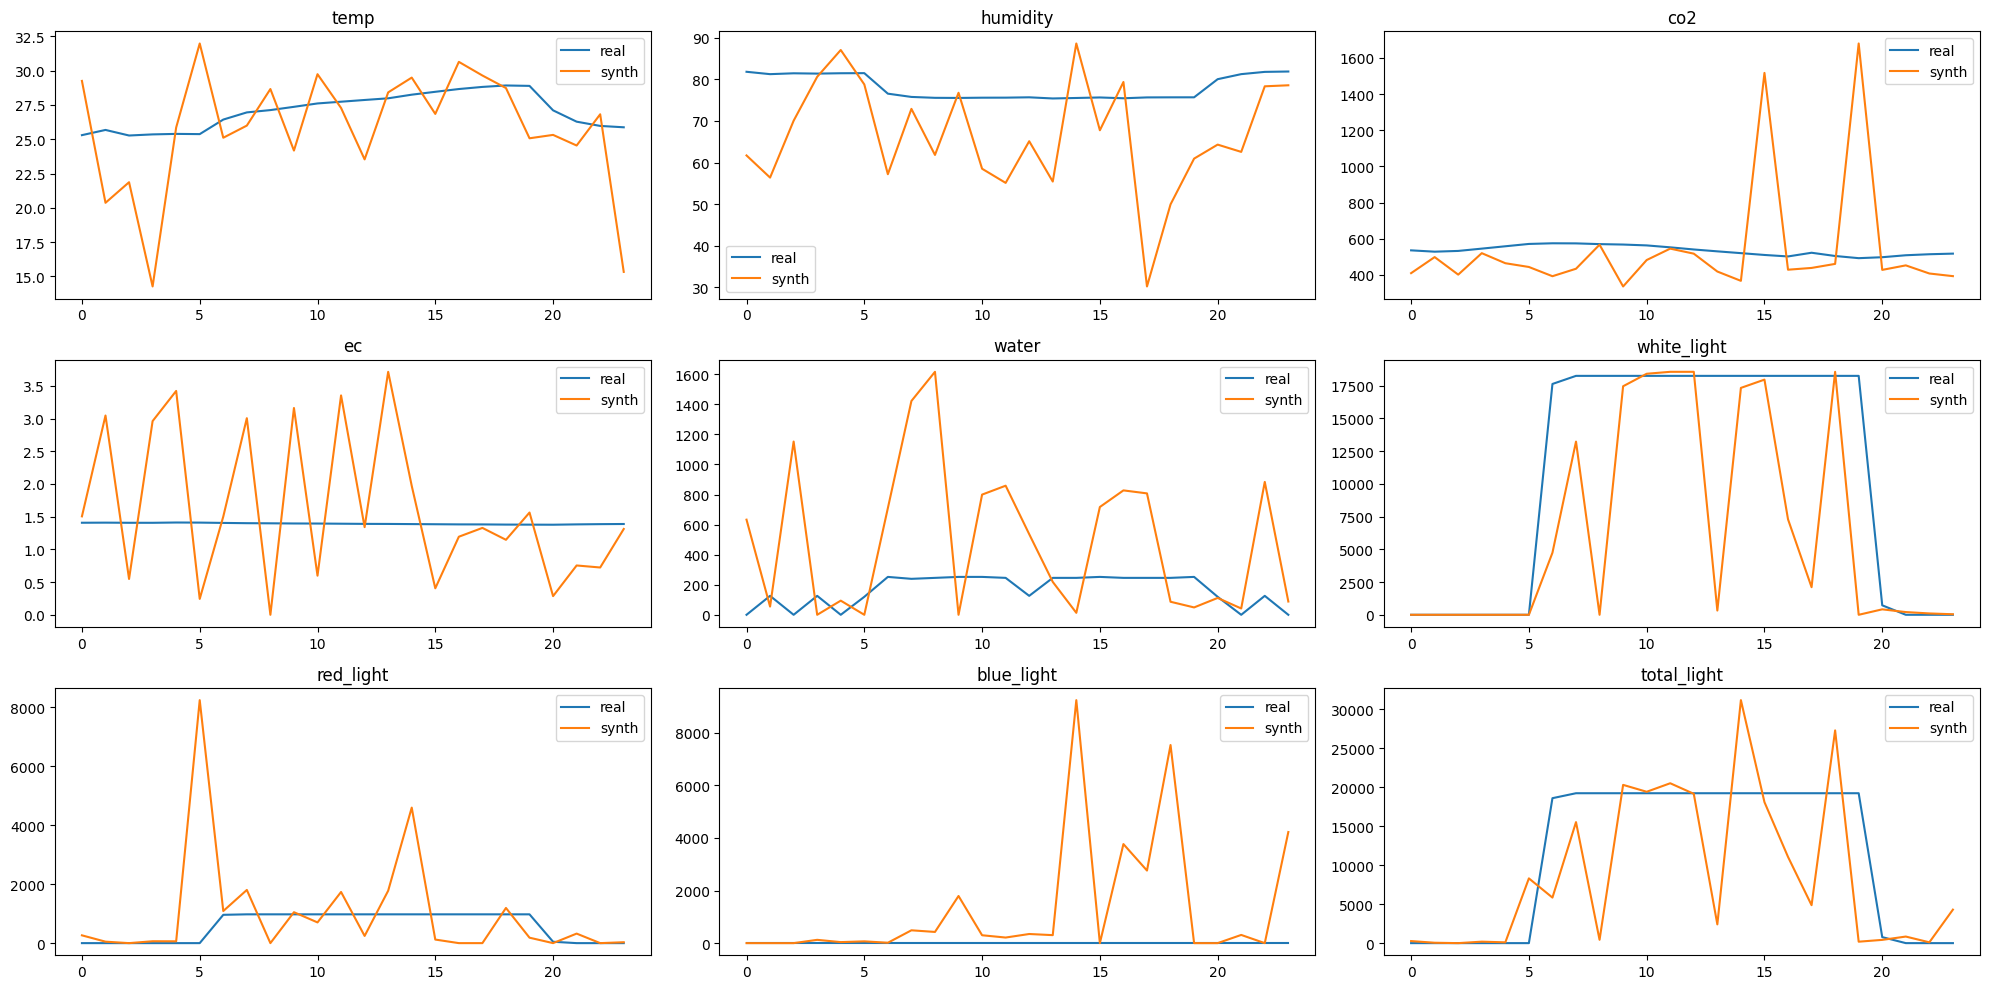

In [ ]:
plot_real_synth(real=train_c1d0, synth=synth)

In [ ]:
cond_synth = generate_cond_synth(synthesizer, 1)

Sampling conditions: 100%|██████████| 1/1 [00:21<00:00, 21.11s/it]


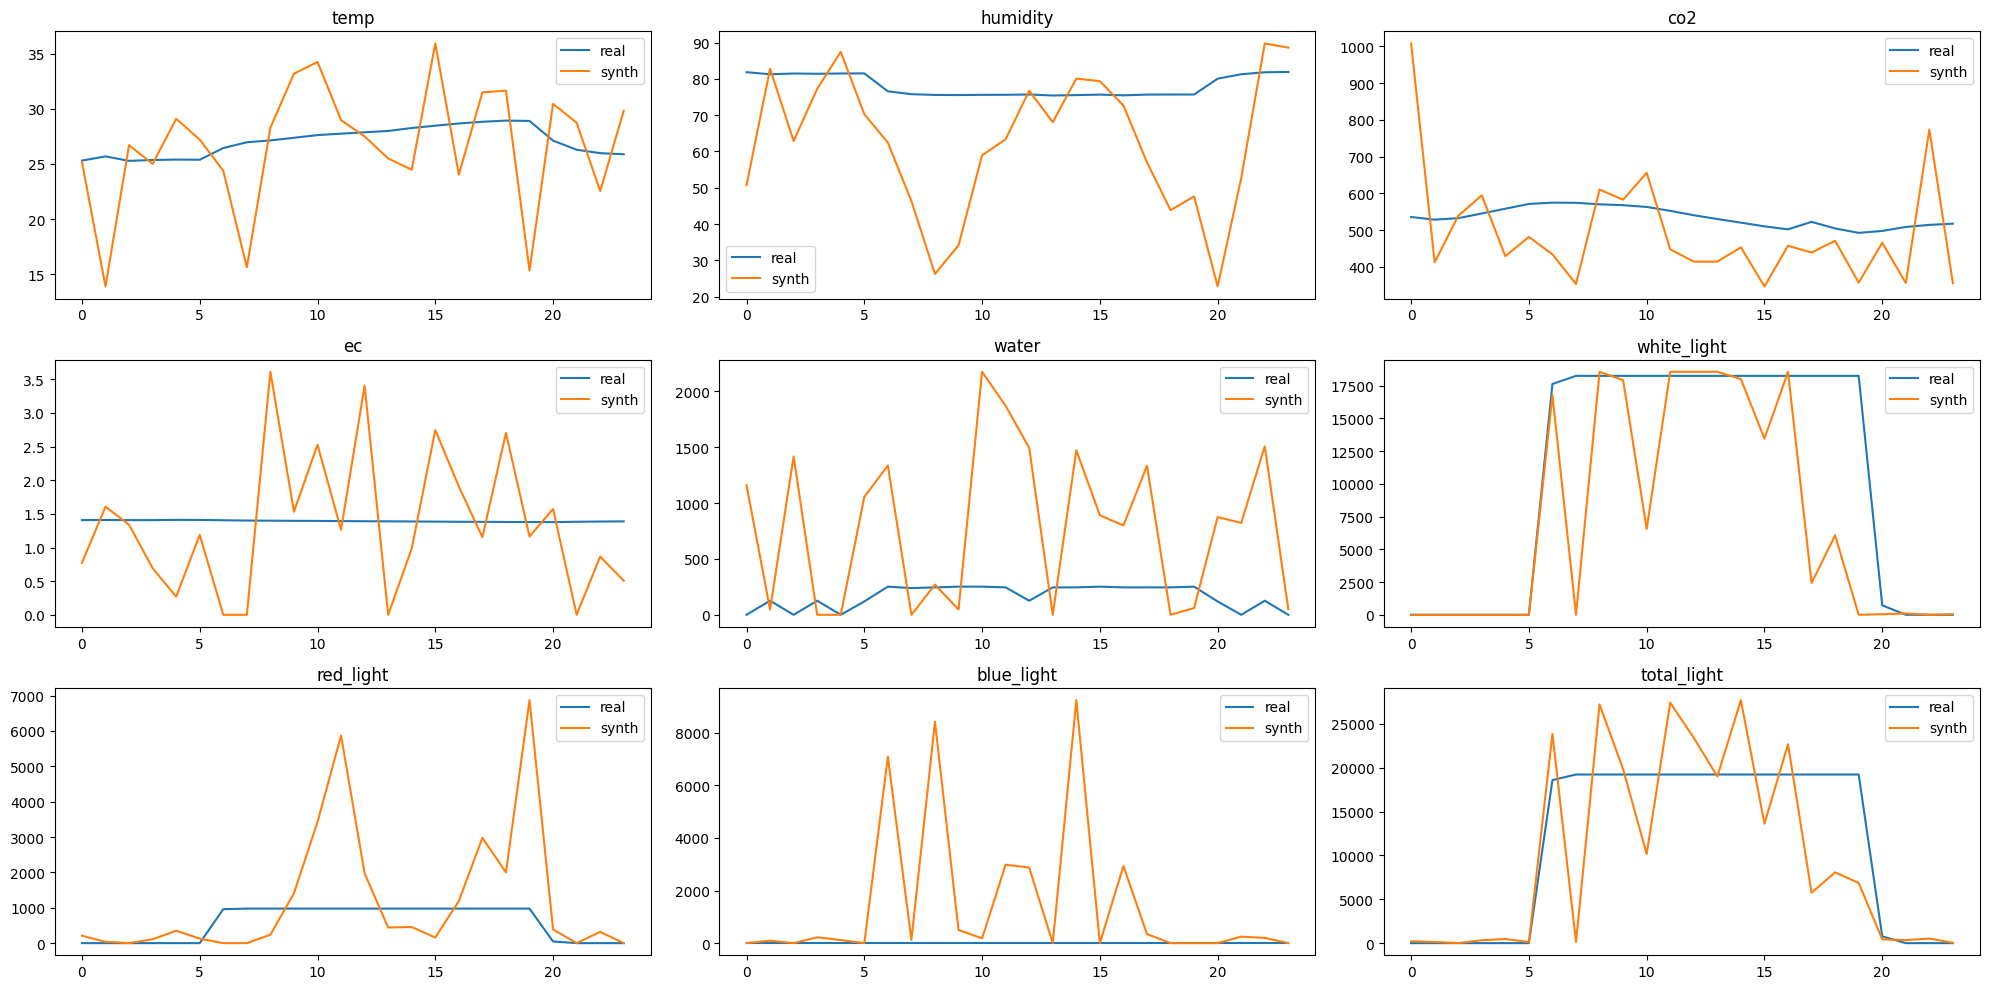

In [ ]:
plot_real_synth(real=train_c1d0, synth=cond_synth)

2. Train input - CASE_20.csv

In [ ]:
input_dir_list = ['/content/dataset/train_input/CASE_20.csv']
train_c20 = make_traindata_ctgan(input_dir_list)

In [ ]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(train_c20)

In [ ]:
synthesizer = CTGANSynthesizer(metadata, epochs=300, verbose=True)
synthesizer.fit(train_c20)

In [ ]:
!mkdir /mydrive/model_param/CASE_20
synthesizer.save(filepath='/mydrive/model_param/CASE_20/gen_model.pkl')

In [ ]:
synth = generate_synth(synthesizer, 1)

In [ ]:
real_c20 = pd.read_csv('/content/dataset/train_input/CASE_20.csv')
real_c20d0 = real_c20[real_c20['DAT'] == 0]

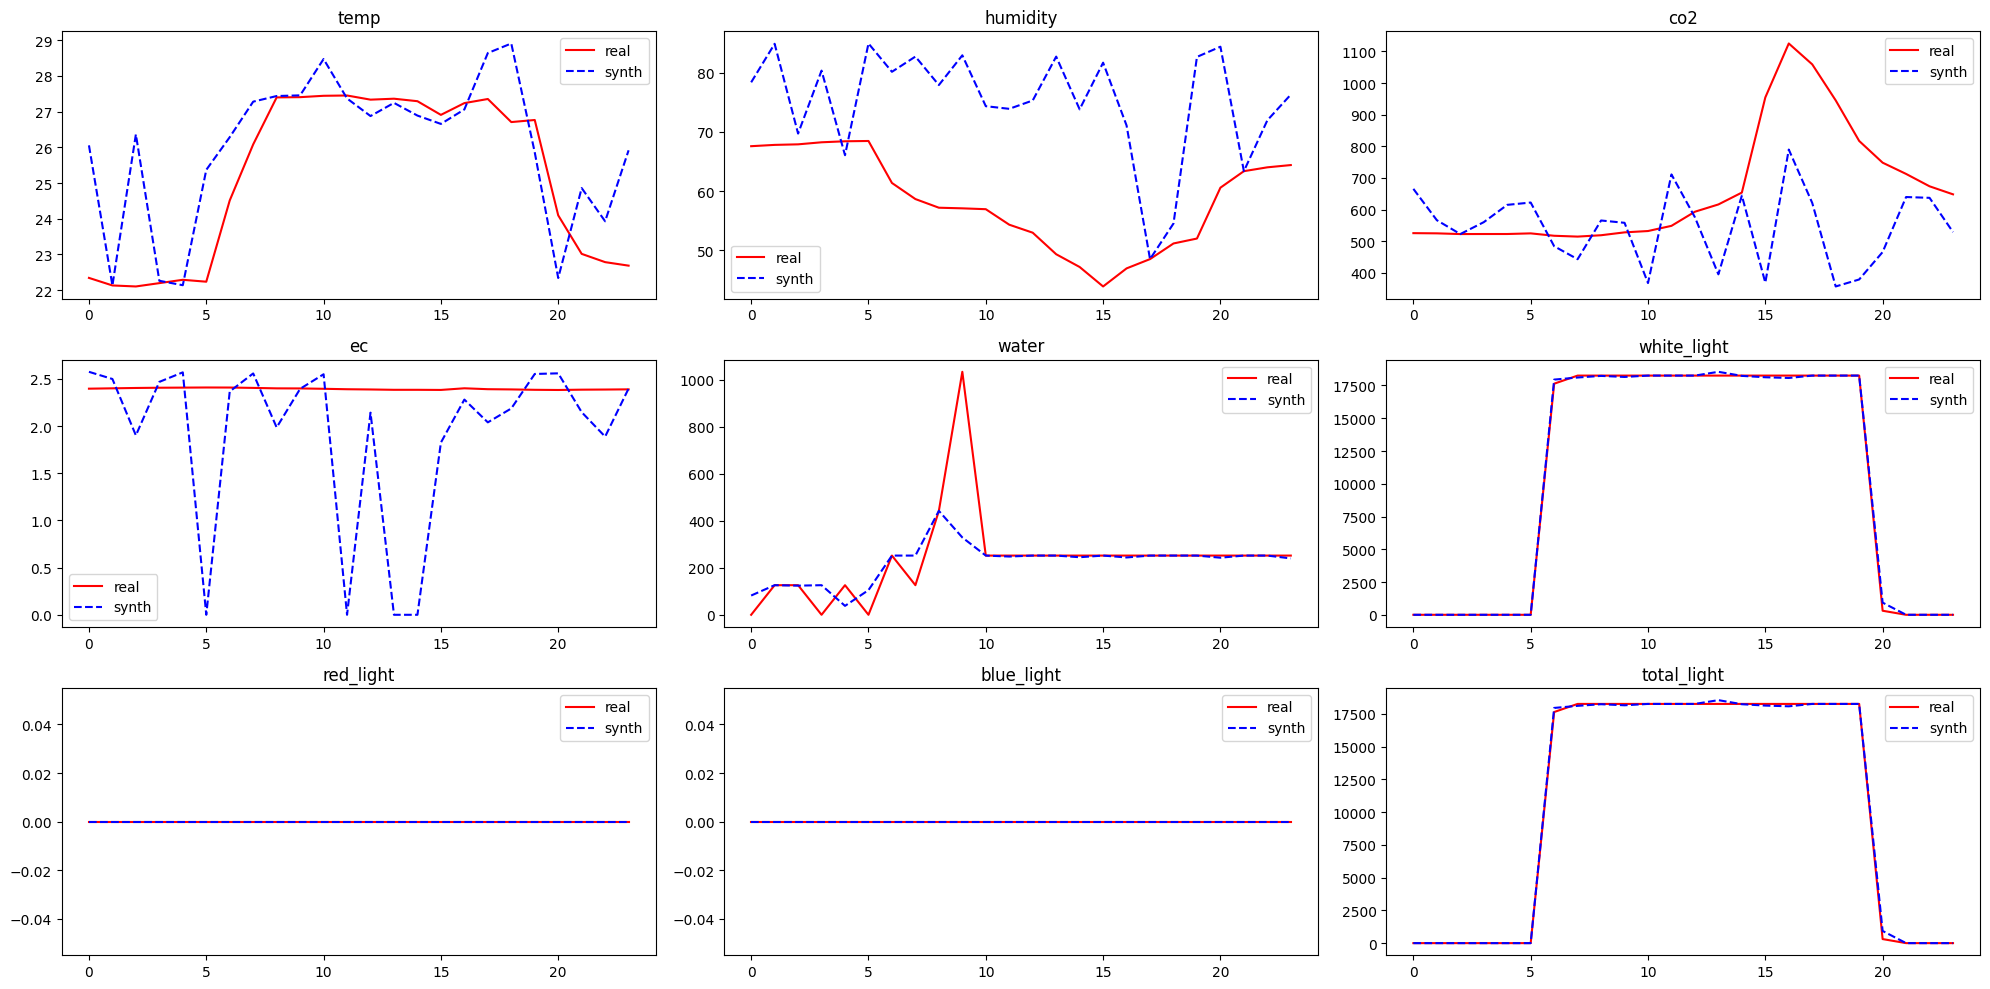

In [ ]:
plot_real_synth(real=real_c20d0, synth=synth)

In [ ]:
cond_synth = generate_cond_synth(synthesizer, 1)

Sampling conditions: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


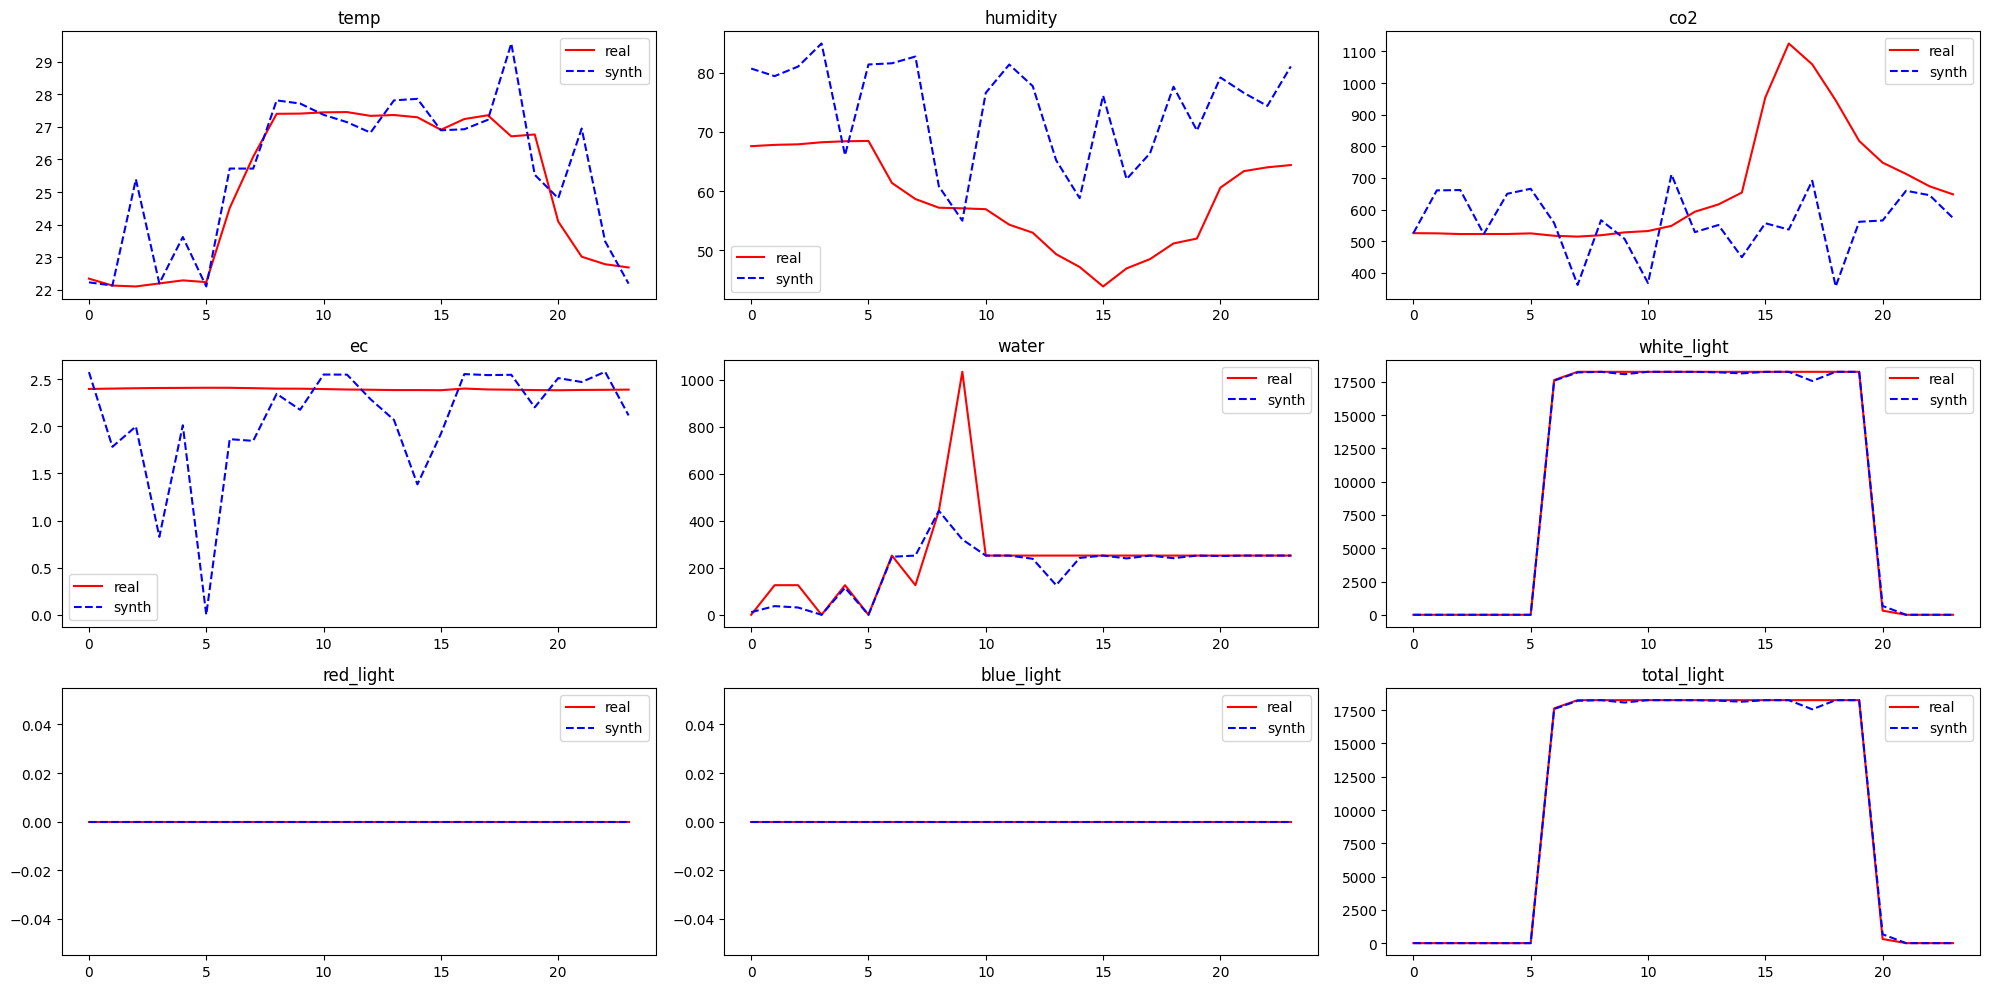

In [ ]:
plot_real_synth(real=real_c20d0, synth=cond_synth)

### Challenges

* Synthetic data is not smooth but fluctuate a lot.
* Time series data has a ***temporal aspec***t; temporal dependencies, seasonality, trends, and other complex patterns.
* CTGAN is a generative adversarial network designed for generating synthetic tabular data.
* CTGAN may not be the most appropriate choice for time series data tasks.
* A good generative model for time-series data should preserve ***temporal dynamics***.

### CPAR

In [6]:
synthesizer = PARSynthesizer.load(filepath='/mydrive/model_param/par_synthesizer.pkl')

In [7]:
train_c1 = pd.read_csv('/content/dataset/train_input/CASE_01.csv') # CASE_01.csv
train_c1d0 = train_c1[train_c1['DAT'] == 0] # 'DAT'=0

In [ ]:
synth = generate_synth(synthesizer, 1)